# Setup

Dependencies:
- System: python3; swig (required for gym[box2d]); ffmpeg, xvfb (for rendering videos)
- Python: jupyter, numpy, matplotlib; gym[box2d] (for RL environment); jax, equinox, optax (for training neural networks); opencv-python, pyvirtualdisplay (for rendering videos)

Example setup for a Ubuntu system (Mac users, maybe `brew` instead of `sudo apt`; Windows users, learn to love [WSL](https://docs.microsoft.com/en-us/windows/wsl/install-win10)):
```
sudo apt install swig ffmpeg xvfb
/usr/bin/python3 -m pip install --upgrade pip
pip install --upgrade jupyter numpy matplotlib gym[box2d] jax equinox optax opencv-python pyvirtualdisplay
jupyter notebook  # from the directory of this notebook
```
Alternatively, view this notebook on [Google Colab](https://colab.research.google.com/github/StanfordASL/AA203-Examples/blob/master/Lecture-18/Advantage%20Actor%20Critic%20%28A2C%29%20--%20Lunar%20Lander.ipynb) and run a cell containing these commands:
```
!apt-get install xvfb -y
!pip install --upgrade gym[box2d]==0.23.1 equinox optax pyvirtualdisplay
%env PYTHON_PATH=/usr/local/lib/python3.7/dist-packages
```

In [1]:
import gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt; plt.rcParams.update({'font.size': 20})
import numpy as np

import equinox as eqx
import optax

In [2]:
# UX options.
render_style = "notebook"  # Can be `None`, "window", "file", or "notebook"
render_interval = 100
video_file_directory = "lunar_lander_episodes"

# RL environment setup.
env = gym.make("LunarLanderContinuous-v2")
env.reset(seed=0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_steps = 600

# Training parameters.
discount_factor = 0.99  # Discount factor for computing tail returns.
ema_factor = 0.99  # Exponential moving average for standardizing returns.
key = jax.random.PRNGKey(0)  # Random seed for NN initialization, action sampling.

# Code for rendering videos if not using standard gym[box2d] pygame visualization ("window" option).
if render_style == "file" or render_style == "notebook":
    import os
    import cv2
    from pyvirtualdisplay import Display
    os.makedirs(video_file_directory, exist_ok=True)
    Display(visible=False, size=(1400, 900)).start()


def display_local_video_in_notebook(filename, size=(600, 400)):
    try:
        get_ipython()
        from IPython.display import HTML
    except (NameError, ImportError):
        raise RuntimeError("`display_local_video_in_notebook` must be called from jupyter/colab.")

    import base64
    import os
    # Re-encode video to x264.
    os.system(f"ffmpeg -y -i {filename} -vcodec libx264 {filename}.x264.mp4")
    os.replace(filename + ".x264.mp4", filename)
    # Convert to base64 for display in notebook.
    with open(filename, "rb") as f:
        video_data = "data:video/mp4;base64," + base64.b64encode(f.read()).decode()
    display(
        HTML(f"""
            <video width="{size[0]}" height="{size[1]}" controls autoplay loop>
                <source type="video/mp4" src="{video_data}">
                Your browser does not support the video tag.
            </video>
        """))

In [3]:
class Policy(eqx.Module):
    trunk_layers: list
    action_mean_head: eqx.Module
    action_std_head: eqx.Module
    value_head: eqx.Module

    def __init__(self, key):
        # `PRNGKey`s for initializing NN layers.
        keys = jax.random.split(key, 5)
        # Embedding layers.
        self.trunk_layers = [
            eqx.nn.Linear(state_dim, 128, key=keys[0]),
            eqx.nn.Linear(128, 128, key=keys[1]),
        ]
        # Actor's layers.
        self.action_mean_head = eqx.nn.Linear(128, action_dim, key=keys[2])
        self.action_std_head = eqx.nn.Linear(128, action_dim, key=keys[3])
        # Critic's layers.
        self.value_head = eqx.nn.Linear(128, 1, key=keys[4])

    @jax.jit
    def __call__(self, x):
        for layer in self.trunk_layers:
            x = jax.nn.relu(layer(x))
        action_mean = self.action_mean_head(x)
        action_std = jax.nn.softplus(self.action_std_head(x))
        value = self.value_head(x)[0]
        return MultivariateNormalDiag(action_mean, action_std), value


class MultivariateNormalDiag(eqx.Module):
    # Cheap knockoff of `tensorflow_probability.substrates.jax.distributions.MultivariateNormalDiag`.
    mean: jnp.array
    std: jnp.array

    @jax.jit
    def sample(self, key, shape=()):
        return self.mean + self.std * jax.random.normal(key, shape + self.mean.shape)

    @jax.jit
    def log_prob(self, value):
        return jnp.sum(jax.scipy.stats.norm.logpdf(value, self.mean, self.std), -1)


def compute_returns(rewards, discount_factor):
    tail_return = 0.
    returns = []
    for r in rewards[::-1]:
        tail_return = r + discount_factor * tail_return
        returns.append(tail_return)
    returns.reverse()
    return np.array(returns)


def train_loss_for_epsiode(policy, states, actions, returns, num_steps):
    action_distributions, values = jax.vmap(policy)(states)
    action_log_probs = action_distributions.log_prob(actions)
    advantages = returns - values
    mask = jnp.arange(max_steps) < num_steps
    actor_loss = jnp.sum(-action_log_probs * jax.lax.stop_gradient(advantages) * mask)
    critic_loss = jnp.sum(jnp.square(advantages) * mask)
    return actor_loss + critic_loss


@jax.jit
def train_step_for_episode(opt_state, policy, states, actions, returns, num_steps):
    grads = jax.grad(train_loss_for_epsiode)(policy, states, actions, returns, num_steps)
    updates, opt_state = optimizer.update(grads, opt_state)
    policy = optax.apply_updates(policy, updates)
    return opt_state, policy

In [4]:
key, policy_key = jax.random.split(key)
policy = Policy(policy_key)
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(policy)

episodic_rewards = []
episodic_reward_ema = None  # Exponential moving average of episodic rewards.
return_ema = None  # Exponential moving average of returns (i.e., critic targets).
return_emv = None  # Exponential moving variance of returns (i.e., critic targets).
for i_episode in range(3001):

    # Reset environment at the start of each episode, and clear accumulators.
    state = env.reset()
    episodic_reward = 0
    states = []
    actions = []
    rewards = []

    # Sample a trajectory (episode) according to our stochastic policy/environment dynamics.
    for t in range(max_steps):
        states.append(state)
        action_distribution, _ = policy(state)
        key, sample_key = jax.random.split(key)
        action = np.array(action_distribution.sample(sample_key))  # Leave JAX to interact with gym.
        state, reward, done, _ = env.step(action)
        episodic_reward += reward
        actions.append(action)
        rewards.append(reward)
        if render_style is not None and i_episode % render_interval == 0:
            if render_style == "window":
                env.render()
            elif render_style == "file" or render_style == "notebook":
                if t == 0:
                    video_filename = f"{video_file_directory}/lunar_lander_episode_{i_episode}.mp4"
                    video = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*"mp4v"), 50, (600, 400))
                video.write(env.render("rgb_array"))
            else:
                raise ValueError("`render_style` must be `None`, 'window', 'file', or 'notebook'.")
        if done:
            break

    # Compute (standardized) tail returns for the episode and update moving averages.
    episodic_rewards.append(episodic_reward)
    returns = compute_returns(rewards, discount_factor)
    if i_episode == 0:
        episodic_reward_ema = episodic_reward
        return_ema = returns.mean()
        return_emv = returns.var()
    else:
        episodic_reward_ema = 0.95 * episodic_reward_ema + (1 - 0.95) * episodic_reward
        return_ema = ema_factor * return_ema + (1 - ema_factor) * returns.mean()
        return_emv = ema_factor * (return_emv + (1 - ema_factor) * np.mean((returns - return_ema)**2))
    # Side note: for students with deep learning experience, standardizing returns
    # using moving population statistics may be reminiscent of batch normalization.
    standardized_returns = (returns - return_ema) / (np.sqrt(return_emv) + 1e-6)

    # Run a train step based on the episode's data.
    num_steps = len(states)
    # JAX prefers all arrays to be the same shape, so we pad to the batch size.
    opt_state, policy = train_step_for_episode(
        opt_state,
        policy,
        np.pad(states, ((0, max_steps - num_steps), (0, 0))),
        np.pad(actions, ((0, max_steps - num_steps), (0, 0))),
        np.pad(standardized_returns, ((0, max_steps - num_steps),)),
        num_steps,
    )

    # Periodically log results.
    if i_episode % 10 == 0:
        print(
            f"Episode {i_episode}\tLast reward: {episodic_reward:.2f}\tMoving average reward: {episodic_reward_ema:.2f}"
        )

    # Save/display video; this video corresponds to the most recently printed "Last reward".
    if (render_style == "file" or render_style == "notebook") and i_episode % render_interval == 0:
        video.release()
        if render_style == "notebook":
            display_local_video_in_notebook(video_filename)

Episode 0	Last reward: -283.28	Moving average reward: -283.28


Episode 10	Last reward: -217.71	Moving average reward: -264.02
Episode 20	Last reward: -138.99	Moving average reward: -247.87
Episode 30	Last reward: -330.98	Moving average reward: -206.85
Episode 40	Last reward: -148.23	Moving average reward: -241.40
Episode 50	Last reward: -411.88	Moving average reward: -280.08
Episode 60	Last reward: -444.93	Moving average reward: -297.42
Episode 70	Last reward: -47.01	Moving average reward: -260.36
Episode 80	Last reward: -192.80	Moving average reward: -256.27
Episode 90	Last reward: -415.41	Moving average reward: -224.33
Episode 100	Last reward: -101.92	Moving average reward: -217.03


Episode 110	Last reward: -55.70	Moving average reward: -217.14
Episode 120	Last reward: -75.22	Moving average reward: -193.24
Episode 130	Last reward: -98.20	Moving average reward: -183.47
Episode 140	Last reward: -522.32	Moving average reward: -213.27
Episode 150	Last reward: -185.16	Moving average reward: -230.77
Episode 160	Last reward: -262.86	Moving average reward: -218.71
Episode 170	Last reward: -78.50	Moving average reward: -222.35
Episode 180	Last reward: -235.67	Moving average reward: -192.83
Episode 190	Last reward: -280.65	Moving average reward: -171.66
Episode 200	Last reward: -378.40	Moving average reward: -187.71


Episode 210	Last reward: -198.04	Moving average reward: -183.68
Episode 220	Last reward: -296.49	Moving average reward: -174.56
Episode 230	Last reward: 27.03	Moving average reward: -168.29
Episode 240	Last reward: -121.77	Moving average reward: -167.28
Episode 250	Last reward: -82.02	Moving average reward: -137.39
Episode 260	Last reward: -203.40	Moving average reward: -124.29
Episode 270	Last reward: -154.58	Moving average reward: -144.33
Episode 280	Last reward: -88.05	Moving average reward: -146.54
Episode 290	Last reward: -147.28	Moving average reward: -138.67
Episode 300	Last reward: -53.40	Moving average reward: -121.01


Episode 310	Last reward: -133.39	Moving average reward: -140.17
Episode 320	Last reward: -110.29	Moving average reward: -127.86
Episode 330	Last reward: -50.43	Moving average reward: -127.35
Episode 340	Last reward: -80.59	Moving average reward: -139.59
Episode 350	Last reward: -58.95	Moving average reward: -164.31
Episode 360	Last reward: -292.94	Moving average reward: -144.51
Episode 370	Last reward: -70.18	Moving average reward: -122.40
Episode 380	Last reward: -126.69	Moving average reward: -131.90
Episode 390	Last reward: -44.73	Moving average reward: -109.56
Episode 400	Last reward: -9.72	Moving average reward: -102.49


Episode 410	Last reward: -42.28	Moving average reward: -83.11
Episode 420	Last reward: -35.10	Moving average reward: -67.77
Episode 430	Last reward: -8.35	Moving average reward: -60.82
Episode 440	Last reward: 8.86	Moving average reward: -48.74
Episode 450	Last reward: -34.29	Moving average reward: -48.47
Episode 460	Last reward: -47.66	Moving average reward: -39.81
Episode 470	Last reward: -15.09	Moving average reward: -38.13
Episode 480	Last reward: -24.78	Moving average reward: -29.60
Episode 490	Last reward: 2.30	Moving average reward: -27.80
Episode 500	Last reward: -18.42	Moving average reward: -16.41


Episode 510	Last reward: -20.35	Moving average reward: -9.80
Episode 520	Last reward: -96.98	Moving average reward: -14.96
Episode 530	Last reward: 6.03	Moving average reward: -19.96
Episode 540	Last reward: -20.76	Moving average reward: -16.38
Episode 550	Last reward: -35.30	Moving average reward: -43.35
Episode 560	Last reward: 38.95	Moving average reward: -48.05
Episode 570	Last reward: -86.41	Moving average reward: -45.72
Episode 580	Last reward: -46.56	Moving average reward: -47.92
Episode 590	Last reward: 10.52	Moving average reward: -37.64
Episode 600	Last reward: -36.49	Moving average reward: -31.79


Episode 610	Last reward: -13.08	Moving average reward: -26.45
Episode 620	Last reward: -9.73	Moving average reward: -33.59
Episode 630	Last reward: 50.11	Moving average reward: -23.08
Episode 640	Last reward: -301.11	Moving average reward: -82.81
Episode 650	Last reward: -13.21	Moving average reward: -57.05
Episode 660	Last reward: 39.92	Moving average reward: -33.68
Episode 670	Last reward: 27.22	Moving average reward: -14.76
Episode 680	Last reward: -34.41	Moving average reward: -19.52
Episode 690	Last reward: 32.90	Moving average reward: -5.25
Episode 700	Last reward: 59.81	Moving average reward: 0.47


Episode 710	Last reward: 68.54	Moving average reward: 8.29
Episode 720	Last reward: -13.04	Moving average reward: -0.41
Episode 730	Last reward: 37.13	Moving average reward: 2.45
Episode 740	Last reward: -28.14	Moving average reward: 13.57
Episode 750	Last reward: 92.25	Moving average reward: 21.15
Episode 760	Last reward: 52.37	Moving average reward: 14.14
Episode 770	Last reward: 3.38	Moving average reward: 6.18
Episode 780	Last reward: 67.91	Moving average reward: 15.63
Episode 790	Last reward: 54.84	Moving average reward: 10.86
Episode 800	Last reward: 57.14	Moving average reward: 17.16


Episode 810	Last reward: 30.41	Moving average reward: 19.33
Episode 820	Last reward: -47.18	Moving average reward: 6.72
Episode 830	Last reward: 14.20	Moving average reward: 23.76
Episode 840	Last reward: 60.99	Moving average reward: 34.49
Episode 850	Last reward: 90.33	Moving average reward: 45.71
Episode 860	Last reward: 96.93	Moving average reward: 56.61
Episode 870	Last reward: 73.51	Moving average reward: 50.10
Episode 880	Last reward: -3.82	Moving average reward: 42.47
Episode 890	Last reward: -23.46	Moving average reward: 18.58
Episode 900	Last reward: 71.69	Moving average reward: 37.83


Episode 910	Last reward: 69.00	Moving average reward: 32.49
Episode 920	Last reward: 101.71	Moving average reward: 38.03
Episode 930	Last reward: 13.40	Moving average reward: 42.44
Episode 940	Last reward: 18.04	Moving average reward: 50.08
Episode 950	Last reward: 2.14	Moving average reward: 60.18
Episode 960	Last reward: 28.33	Moving average reward: 38.24
Episode 970	Last reward: 117.24	Moving average reward: 30.72
Episode 980	Last reward: -34.45	Moving average reward: 31.47
Episode 990	Last reward: 69.67	Moving average reward: 34.60
Episode 1000	Last reward: -6.67	Moving average reward: 41.32


Episode 1010	Last reward: 111.23	Moving average reward: 49.67
Episode 1020	Last reward: 67.06	Moving average reward: 57.58
Episode 1030	Last reward: 14.47	Moving average reward: 47.87
Episode 1040	Last reward: 20.70	Moving average reward: 44.18
Episode 1050	Last reward: 7.66	Moving average reward: 36.26
Episode 1060	Last reward: -193.09	Moving average reward: 20.84
Episode 1070	Last reward: 36.80	Moving average reward: 25.35
Episode 1080	Last reward: 38.27	Moving average reward: 32.06
Episode 1090	Last reward: 76.26	Moving average reward: 32.94
Episode 1100	Last reward: 28.03	Moving average reward: 42.44


Episode 1110	Last reward: 36.13	Moving average reward: 42.19
Episode 1120	Last reward: -28.41	Moving average reward: 28.74
Episode 1130	Last reward: 30.35	Moving average reward: 26.02
Episode 1140	Last reward: 73.42	Moving average reward: 24.77
Episode 1150	Last reward: 9.65	Moving average reward: 29.48
Episode 1160	Last reward: 82.66	Moving average reward: 47.83
Episode 1170	Last reward: -27.97	Moving average reward: 45.25
Episode 1180	Last reward: -26.01	Moving average reward: 40.42
Episode 1190	Last reward: 101.64	Moving average reward: 41.87
Episode 1200	Last reward: 109.55	Moving average reward: 47.74


Episode 1210	Last reward: 9.87	Moving average reward: 54.84
Episode 1220	Last reward: 17.78	Moving average reward: 56.57
Episode 1230	Last reward: 59.97	Moving average reward: 61.18
Episode 1240	Last reward: 91.19	Moving average reward: 61.11
Episode 1250	Last reward: 118.52	Moving average reward: 72.68
Episode 1260	Last reward: 129.00	Moving average reward: 67.05
Episode 1270	Last reward: 40.79	Moving average reward: 62.61
Episode 1280	Last reward: 5.79	Moving average reward: 55.32
Episode 1290	Last reward: 62.77	Moving average reward: 57.26
Episode 1300	Last reward: 128.54	Moving average reward: 78.48


Episode 1310	Last reward: 91.39	Moving average reward: 82.59
Episode 1320	Last reward: 35.44	Moving average reward: 73.27
Episode 1330	Last reward: 135.66	Moving average reward: 85.98
Episode 1340	Last reward: 24.79	Moving average reward: 81.71
Episode 1350	Last reward: 118.61	Moving average reward: 80.06
Episode 1360	Last reward: 93.44	Moving average reward: 82.56
Episode 1370	Last reward: 98.80	Moving average reward: 81.87
Episode 1380	Last reward: 56.72	Moving average reward: 87.30
Episode 1390	Last reward: 88.57	Moving average reward: 78.77
Episode 1400	Last reward: 110.89	Moving average reward: 84.47


Episode 1410	Last reward: 75.18	Moving average reward: 88.00
Episode 1420	Last reward: 131.54	Moving average reward: 91.07
Episode 1430	Last reward: 87.97	Moving average reward: 97.55
Episode 1440	Last reward: 138.78	Moving average reward: 97.43
Episode 1450	Last reward: 149.80	Moving average reward: 97.91
Episode 1460	Last reward: 85.16	Moving average reward: 89.96
Episode 1470	Last reward: 145.26	Moving average reward: 109.24
Episode 1480	Last reward: 134.69	Moving average reward: 100.55
Episode 1490	Last reward: -13.85	Moving average reward: 86.58
Episode 1500	Last reward: 1.79	Moving average reward: 63.57


Episode 1510	Last reward: 18.36	Moving average reward: 56.33
Episode 1520	Last reward: 36.86	Moving average reward: 67.95
Episode 1530	Last reward: 12.70	Moving average reward: 68.18
Episode 1540	Last reward: 149.73	Moving average reward: 81.85
Episode 1550	Last reward: 118.67	Moving average reward: 84.14
Episode 1560	Last reward: 134.18	Moving average reward: 92.13
Episode 1570	Last reward: 135.68	Moving average reward: 95.52
Episode 1580	Last reward: 164.97	Moving average reward: 114.17
Episode 1590	Last reward: 145.17	Moving average reward: 111.70
Episode 1600	Last reward: 18.26	Moving average reward: 107.47


Episode 1610	Last reward: 160.59	Moving average reward: 103.27
Episode 1620	Last reward: 92.41	Moving average reward: 108.67
Episode 1630	Last reward: 152.19	Moving average reward: 107.56
Episode 1640	Last reward: 124.00	Moving average reward: 92.72
Episode 1650	Last reward: 162.95	Moving average reward: 96.14
Episode 1660	Last reward: 140.42	Moving average reward: 104.56
Episode 1670	Last reward: 125.80	Moving average reward: 105.30
Episode 1680	Last reward: 147.79	Moving average reward: 94.74
Episode 1690	Last reward: 149.99	Moving average reward: 107.29
Episode 1700	Last reward: 10.55	Moving average reward: 105.34


Episode 1710	Last reward: 132.67	Moving average reward: 119.32
Episode 1720	Last reward: 162.12	Moving average reward: 116.89
Episode 1730	Last reward: 108.06	Moving average reward: 128.01
Episode 1740	Last reward: 178.99	Moving average reward: 136.49
Episode 1750	Last reward: 118.52	Moving average reward: 139.33
Episode 1760	Last reward: 33.53	Moving average reward: 116.68
Episode 1770	Last reward: 28.69	Moving average reward: 111.39
Episode 1780	Last reward: 172.85	Moving average reward: 116.21
Episode 1790	Last reward: 152.26	Moving average reward: 118.61
Episode 1800	Last reward: 5.81	Moving average reward: 119.16


Episode 1810	Last reward: 153.33	Moving average reward: 126.00
Episode 1820	Last reward: 127.96	Moving average reward: 129.00
Episode 1830	Last reward: 130.78	Moving average reward: 127.01
Episode 1840	Last reward: 165.34	Moving average reward: 135.39
Episode 1850	Last reward: 127.84	Moving average reward: 141.21
Episode 1860	Last reward: 163.59	Moving average reward: 138.55
Episode 1870	Last reward: 168.16	Moving average reward: 145.69
Episode 1880	Last reward: 142.54	Moving average reward: 145.72
Episode 1890	Last reward: 134.80	Moving average reward: 142.67
Episode 1900	Last reward: 150.46	Moving average reward: 151.36


Episode 1910	Last reward: 165.44	Moving average reward: 156.91
Episode 1920	Last reward: 183.86	Moving average reward: 158.45
Episode 1930	Last reward: 158.40	Moving average reward: 157.11
Episode 1940	Last reward: 147.25	Moving average reward: 158.45
Episode 1950	Last reward: 130.11	Moving average reward: 170.77
Episode 1960	Last reward: 115.24	Moving average reward: 179.34
Episode 1970	Last reward: 247.15	Moving average reward: 195.47
Episode 1980	Last reward: 18.88	Moving average reward: 200.00
Episode 1990	Last reward: 252.84	Moving average reward: 189.08
Episode 2000	Last reward: 66.11	Moving average reward: 175.77


Episode 2010	Last reward: 266.24	Moving average reward: 208.21
Episode 2020	Last reward: 16.32	Moving average reward: 187.15
Episode 2030	Last reward: 132.11	Moving average reward: 198.46
Episode 2040	Last reward: 226.31	Moving average reward: 193.55
Episode 2050	Last reward: 290.66	Moving average reward: 216.01
Episode 2060	Last reward: 260.73	Moving average reward: 205.88
Episode 2070	Last reward: 152.30	Moving average reward: 192.05
Episode 2080	Last reward: 258.06	Moving average reward: 219.18
Episode 2090	Last reward: 295.22	Moving average reward: 228.04
Episode 2100	Last reward: 238.06	Moving average reward: 226.41


Episode 2110	Last reward: 282.79	Moving average reward: 218.40
Episode 2120	Last reward: 250.53	Moving average reward: 233.20
Episode 2130	Last reward: 162.54	Moving average reward: 225.60
Episode 2140	Last reward: 150.39	Moving average reward: 232.26
Episode 2150	Last reward: 141.33	Moving average reward: 228.20
Episode 2160	Last reward: 14.37	Moving average reward: 225.64
Episode 2170	Last reward: 186.53	Moving average reward: 231.02
Episode 2180	Last reward: 228.26	Moving average reward: 235.91
Episode 2190	Last reward: 247.12	Moving average reward: 239.79
Episode 2200	Last reward: 146.67	Moving average reward: 222.24


Episode 2210	Last reward: 268.38	Moving average reward: 231.12
Episode 2220	Last reward: -0.35	Moving average reward: 228.24
Episode 2230	Last reward: 235.71	Moving average reward: 240.58
Episode 2240	Last reward: 36.62	Moving average reward: 229.65
Episode 2250	Last reward: 117.78	Moving average reward: 221.12
Episode 2260	Last reward: 282.88	Moving average reward: 233.01
Episode 2270	Last reward: 260.44	Moving average reward: 244.85
Episode 2280	Last reward: 243.16	Moving average reward: 249.46
Episode 2290	Last reward: 157.92	Moving average reward: 224.71
Episode 2300	Last reward: -2.41	Moving average reward: 202.79


Episode 2310	Last reward: 207.34	Moving average reward: 202.85
Episode 2320	Last reward: 275.25	Moving average reward: 211.80
Episode 2330	Last reward: 62.60	Moving average reward: 200.42
Episode 2340	Last reward: 278.51	Moving average reward: 207.83
Episode 2350	Last reward: 270.13	Moving average reward: 215.51
Episode 2360	Last reward: 173.63	Moving average reward: 225.51
Episode 2370	Last reward: 277.99	Moving average reward: 244.92
Episode 2380	Last reward: 141.23	Moving average reward: 235.58
Episode 2390	Last reward: 239.83	Moving average reward: 234.69
Episode 2400	Last reward: 270.89	Moving average reward: 254.24


Episode 2410	Last reward: 281.83	Moving average reward: 263.83
Episode 2420	Last reward: 204.71	Moving average reward: 266.12
Episode 2430	Last reward: 105.94	Moving average reward: 259.47
Episode 2440	Last reward: 275.26	Moving average reward: 260.65
Episode 2450	Last reward: 309.53	Moving average reward: 268.11
Episode 2460	Last reward: 275.84	Moving average reward: 265.13
Episode 2470	Last reward: 305.41	Moving average reward: 271.95
Episode 2480	Last reward: 285.98	Moving average reward: 250.42
Episode 2490	Last reward: 63.21	Moving average reward: 177.03
Episode 2500	Last reward: -6.63	Moving average reward: 112.00


Episode 2510	Last reward: 12.66	Moving average reward: 84.75
Episode 2520	Last reward: 140.40	Moving average reward: 96.77
Episode 2530	Last reward: 57.88	Moving average reward: 120.02
Episode 2540	Last reward: 200.40	Moving average reward: 128.99
Episode 2550	Last reward: 174.91	Moving average reward: 169.94
Episode 2560	Last reward: 197.91	Moving average reward: 158.67
Episode 2570	Last reward: 3.29	Moving average reward: 148.31
Episode 2580	Last reward: 226.54	Moving average reward: 154.09
Episode 2590	Last reward: 297.37	Moving average reward: 182.81
Episode 2600	Last reward: 247.29	Moving average reward: 199.48


Episode 2610	Last reward: 34.33	Moving average reward: 179.88
Episode 2620	Last reward: 116.75	Moving average reward: 179.18
Episode 2630	Last reward: 238.11	Moving average reward: 201.38
Episode 2640	Last reward: 216.36	Moving average reward: 221.27
Episode 2650	Last reward: 268.87	Moving average reward: 238.80
Episode 2660	Last reward: 248.10	Moving average reward: 226.10
Episode 2670	Last reward: 267.78	Moving average reward: 242.74
Episode 2680	Last reward: 269.67	Moving average reward: 254.59
Episode 2690	Last reward: 234.76	Moving average reward: 247.49
Episode 2700	Last reward: 306.00	Moving average reward: 253.29


Episode 2710	Last reward: 290.60	Moving average reward: 264.75
Episode 2720	Last reward: 242.84	Moving average reward: 265.68
Episode 2730	Last reward: 241.69	Moving average reward: 262.83
Episode 2740	Last reward: 291.78	Moving average reward: 257.03
Episode 2750	Last reward: 135.22	Moving average reward: 221.88
Episode 2760	Last reward: 268.86	Moving average reward: 225.58
Episode 2770	Last reward: 101.63	Moving average reward: 204.89
Episode 2780	Last reward: 264.84	Moving average reward: 215.80
Episode 2790	Last reward: 32.14	Moving average reward: 212.41
Episode 2800	Last reward: 293.71	Moving average reward: 230.92


Episode 2810	Last reward: 289.88	Moving average reward: 224.16
Episode 2820	Last reward: 258.92	Moving average reward: 232.79
Episode 2830	Last reward: 304.65	Moving average reward: 248.53
Episode 2840	Last reward: 276.34	Moving average reward: 215.72
Episode 2850	Last reward: 289.77	Moving average reward: 225.78
Episode 2860	Last reward: 179.68	Moving average reward: 205.77
Episode 2870	Last reward: 262.99	Moving average reward: 202.02
Episode 2880	Last reward: 251.68	Moving average reward: 206.72
Episode 2890	Last reward: 159.64	Moving average reward: 204.29
Episode 2900	Last reward: 254.29	Moving average reward: 222.16


Episode 2910	Last reward: 243.65	Moving average reward: 232.06
Episode 2920	Last reward: 260.48	Moving average reward: 245.66
Episode 2930	Last reward: 267.75	Moving average reward: 254.47
Episode 2940	Last reward: 297.85	Moving average reward: 259.30
Episode 2950	Last reward: 287.31	Moving average reward: 253.05
Episode 2960	Last reward: 254.70	Moving average reward: 263.13
Episode 2970	Last reward: 292.69	Moving average reward: 256.67
Episode 2980	Last reward: 155.97	Moving average reward: 254.07
Episode 2990	Last reward: 293.60	Moving average reward: 262.83
Episode 3000	Last reward: 282.87	Moving average reward: 250.22


Text(0.5, 1.0, 'Total Reward per Episode')

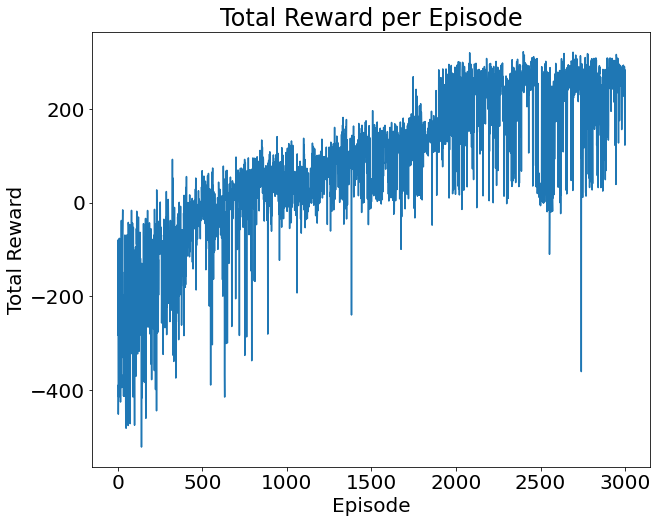

In [5]:
plt.figure(figsize=(10, 8))
plt.plot(episodic_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')